# **Lab Session: n-Gram Language Modeling with TinyStories**

In this lab, we'll implement a simple $n$-gram language model on the **TinyStories** dataset from HuggingFace.
We will:

1. **Download the train/dev splits** of TinyStories.
2. **Build a vocabulary** (with a custom `Vocabulary` class), ensuring we do not load the entire dataset in memory at once.
3. **Implement an $n$-gram language model** with add-one (Laplace) smoothing.
4. **Train** the model (i.e., estimate counts/parameters).
5. **Evaluate** the model using **perplexity** on the dev set.
6. **Compare** results for $n=1,2,3$.
7. **Implement a Feed-Forward Neural Network** parametrization of $n$-gram models.
8. **Implement RNN** based language models.

We'll use vectorization and GPU acceleration for neural network LMs while counting-based $n$-gram LM is CPU-based.


# Part I: Dataset and Vocabulary

In [ ]:
#@title Setup

!pip install datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12

In [ ]:
import time
import math
from collections import Counter, defaultdict
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset

## 1. Downloading and Handling the Data

We'll use the [TinyStories](https://huggingface.co/datasets/roneneldan/TinyStories) dataset from HuggingFace.
It has a *train* split and a *validation* split (which we'll treat as our *dev* set).

In [ ]:
#@title Load Dataset

dataset_name = "roneneldan/TinyStories"  # official HhggingFace name

# if you don't want to store the entire dataset locally, use: load_dataset(dataset_name, split="train", streaming=True)
train_data = load_dataset(dataset_name, split="train", download_mode="reuse_dataset_if_exists")
dev_data   = load_dataset(dataset_name, split="validation", download_mode="reuse_dataset_if_exists")

# Let's peek at a few examples
train_examples_iter = iter(train_data)
for _ in range(3):
    example = next(train_examples_iter)
    print(example)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

{'text': 'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'}
{'text': 'Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had man

The dataset is now cached locally:

In [ ]:
!ls -lh /root/.cache/huggingface/datasets/

total 4.0K
drwxr-xr-x 3 root root 4.0K Jan 30 11:05 roneneldan___tiny_stories
-rw-r--r-- 1 root root    0 Jan 30 11:06 _root_.cache_huggingface_datasets_roneneldan___tiny_stories_default_0.0.0_f54c09fd23315a6f9c86f9dc80f725de7d8f9c64.lock


## 2. Tokenization and Vocabulary Construction

We’ll implement a simple whitespace-based tokenizer for demonstration (though one might use advanced subword tokenizers like BPE, etc. in practice).

### Steps:
1. We load the training dataset.
2. For each example, we split its text on whitespace to get tokens.
3. Accumulate frequency counts in a `Counter`.
4. Decide on how many tokens to keep (or set a frequency threshold).
5. Map low-frequency tokens to `<unk>`.

We’ll create a `Vocabulary` class to handle:
- `build_vocab(...)`: from a frequency dictionary, define `token_to_idx` and `idx_to_token`.
- `encode(...)`: turn a string (list of tokens) into a list of token IDs.
- `decode(...)`: optional, do the reverse if needed.


In [ ]:
#@title Vocabulary Class

class Vocabulary:
    def __init__(self, min_freq=1, specials=("<pad>", "<unk>", "<s>", "</s>")):
        """
        min_freq: minimum frequency threshold for words to be included in the vocab
        specials: special tokens for unknown, start, end
        """
        self.min_freq = min_freq
        self.special_tokens = list(specials)

        self.token_to_idx = {}
        self.idx_to_token = []

        # We'll fill these once we build the vocab
        self.unk_token = specials[1]
        self.unk_idx   = None

    def build_vocab(self, word_freqs):
        """
        word_freqs: a dictionary or Counter of {token -> frequency}.
        We'll keep tokens with freq >= min_freq or that are special tokens.
        Then assign indices in sorted order of freq (descending) for reproducibility.
        """
        # First, ensure special tokens are in the vocab
        for special in self.special_tokens:
            self.token_to_idx[special] = len(self.token_to_idx)

        # Sort by frequency
        sorted_by_freq = # [Insert your code here]

        # Loop over sorted_by_freq to cread token_to_idx while respecting min_freq
        # [Insert your code here]

        # Build idx_to_token (inverse mapping)
        self.idx_to_token = [None] * len(self.token_to_idx)
        # [Insert your code here]

        # store index for <unk>
        self.unk_idx = self.token_to_idx[self.unk_token]

    def __len__(self):
        return # [Insert your code here]

    def token_exists(self, token):
        return # [Insert your code here]

    def to_index(self, token):
        # Return the index if in vocab else <unk> index
        return # [Insert your code here]

    def to_token(self, idx):
        return # [Insert your code here]

    def encode(self, tokens):
        # tokens is a list of strings (already tokenized)
        return [self.to_index(t) for t in tokens]

    def decode(self, indices):
        return # [Insert your code here]


### Build the Vocabulary

Let's define `build_vocabulary` function that:
1. Loop over the train set,
2. Splits text into tokens (naive whitespace),
3. Updates frequency counts,
4. Builds the final `Vocabulary`.

We'll also show some frequency statistics in the end.


In [ ]:
def build_vocabulary(train_iter, min_freq=2, max_train_sequences=None):
    freq_counter = Counter()

    num_examples = 0
    for example in tqdm(train_iter, desc="Building Vocab", unit="examples"):
        text = example["text"]
        tokens = text.strip().split()
        # [Insert your code here]: update freq_counter with tokens

        num_examples += 1
        if max_train_sequences is not None and num_examples >= max_train_sequences:
            break

    print(f"Total examples processed: {num_examples}")
    print(f"Total unique tokens seen: {len(freq_counter)}")

    vocab = Vocabulary(min_freq=min_freq, specials=("<unk>", "<s>", "</s>"))
    # [Insert your code]

    print(f"Vocab size (including specials): {len(vocab)}")
    most_common_10 = freq_counter.most_common(10)
    print("Top 10 most common tokens:", most_common_10)

    return vocab

In [ ]:
vocab = build_vocabulary(train_data, min_freq=5, max_train_sequences=100000)

Building Vocab:   5%|▍         | 99999/2119719 [00:07<02:27, 13725.04examples/s]


Total examples processed: 100000
Total unique tokens seen: 76883
Vocab size (including specials): 29905
Top 10 most common tokens: [('and', 822045), ('the', 776446), ('to', 586907), ('a', 531144), ('was', 445693), ('She', 212630), ('He', 209548), ('her', 194784), ('They', 194624), ('it', 174118)]


At this point, we have:
- A `vocab` object that maps tokens to indices.
- Some stats about how many tokens we included.

**Important**: We'll incorporate *start-of-sentence* (`<s>`) and *end-of-sentence* (`</s>`) tokens in the data when we train our \(n\)-gram model.
We will treat each entire "story" as one sequence, or we could break lines, etc.
For simplicity, let's treat the entire text of each example as a single sequence.


# Part II: Implementation of an n-Gram LM with Smoothing

## 3. NGramLM Class
We'll create a class `NgramLM` that:
- Takes in `n`.
- During training, for each sequence, we add `<s>` tokens at the start (n-1 times) and an `</s>` at the end, then accumulate counts of all `context`, `next_token`.
  - Example: For `n=3`, we prepend 2 `<s>` tokens: `[<s>, <s>, w1, w2, ..., wK, </s>]`.
- We store:
  - `count(context, next_token)`
  - `count(context)`
- We define `p(next_token | context) = (count(context, next_token) + 1) / (count(context) + V)`,
  i.e. **add-one** smoothing, where \(V\) is the vocabulary size.
- For inference, we do `log_prob(next_token | context)` = `log(...)`.
- We then can compute perplexity on dev set by computing negative log-likelihood of the dev data.


In [ ]:
class NgramLM:
    def __init__(self, n, vocab_size, alpha=0.1):
        """
        n: order of the model (1=unigram, 2=bigram, etc.)
        vocab_size: number of unique tokens (for smoothing denominator)
        alpha: smoothing parameter (alpha smoothing, also known as add-alpha)
        """
        self.n = n
        self.vocab_size = vocab_size
        self.alpha = alpha  # <-- alpha smoothing parameter
        self.context_counts = defaultdict(int)
        self.conditional_counts = defaultdict(lambda: defaultdict(int))
        self.is_trained = False

    def train(self, dataset_iter, vocab, max_train_sequences=None):
        """
        Train the n-gram language model on the provided dataset.

        Parameters:
            dataset_iter (iterator): An iterable that yields training examples, each containing a "text" field with the sentence.
            vocab (Vocab): An object representing the vocabulary with methods to_index(token) and an attribute token_to_idx mapping tokens to their indices.
            max_train_sequences (int, optional): Maximum number of sequences to train on. If None, train on the entire dataset. Default is None.

        Operations:
            - Iterates over each sentence in the dataset.
            - Tokenizes the sentence and converts tokens to their corresponding indices using the vocabulary.
            - Adds (n-1) start tokens "<s>" and an end token "</s>" to each sequence for proper context handling.
            - Updates context_counts and conditional_counts based on the observed n-grams.
            - Stops training early if max_train_sequences is specified and reached.

        Returns:
            None
        """
        t0 = time.time()

        # [Insert your code here]

        self.is_trained = True
        t1 = time.time()
        print(f"Training complete on {total_sequences} sequences. Time: {t1 - t0:.2f} sec\n")

    def log_prob(self, context_tuple, next_token):
        """
        Return log p(next_token | context_tuple) with alpha smoothing:
            p = (count(context, next_token) + alpha)
                / (count(context) + alpha * vocab_size)
        """
        # [Insert your code here]
        pass

    def sequence_logp(self, seq_ids):
        if not self.is_trained:
            raise ValueError("Model not trained yet.")

        # Prepend (n-1) <s>, append </s>
        context_pad = [vocab.token_to_idx["<s>"]] * (self.n - 1)
        seq_ids = context_pad + seq_ids + [vocab.token_to_idx["</s>"]]

        total_logp = 0.0
        for i in range(self.n - 1, len(seq_ids)):
            context_tuple = tuple(seq_ids[i - (self.n - 1) : i])
            nxt = seq_ids[i]
            total_logp += self.log_prob(context_tuple, nxt)
        return total_logp


## 4. Implementation of Evaluation using Perplexity

Recall the perplexity definition for a dataset \(D\):
$$
   \text{Perplexity}(D)
   = \exp\Bigl( -\frac{1}{|W|}\sum_{w\in D} \log p_{\theta}(w)\Bigr),
$$
where $|W|$ is the total number of tokens in the dataset, and
$\sum_{w\in D}\log p_{\theta}(w)$ is the log-likelihood of all tokens.

We'll define a function that iterates over the dev set and computes the sum of log-probs and the total number of tokens.
Then compute perplexity from that.
We'll do mini-batching if we wanted GPU parallelization, but since this is a counting-based approach, we'll just do it on CPU.


In [ ]:
def evaluate_perplexity(model, dataset_iter, vocab):
    """
    model: NgramLM
    dataset_iter: dev dataset
    vocab: for tokenizing
    Returns: perplexity (float)
    """
    total_log_prob = 0.0
    total_tokens = 0

    for ex in tqdm(dataset_iter, desc="Evaluating perplexity", unit="sentences"):
        # [Insert your code here]
        # For each example in dev:
        #   1) tokenize => seq_ids
        #   2) compute model.sequence_logp(seq_ids)
        #   3) accumulate total_log_prob and total tokens
    return math.exp(-avg_log_prob)


## 5. Training the n-gram Model

We'll instantiate `NgramLM(n=...)` for 1, 2, and 3, then train each on the training data.
We may limit the training data size if needed, because TinyStories is relatively large.

In [ ]:
# train_data and dev_data are already loaded

def train_ngram_model(n, vocab, max_train_sequences=None, alpha=1):
    model = NgramLM(n=n, vocab_size=len(vocab), alpha=alpha)
    model.train(train_data, vocab, max_train_sequences)
    return model

# We'll do this for n=1,2,3 with different alpha
unigram_model_a01 = train_ngram_model(1, vocab, max_train_sequences=10000, alpha=0.1)
bigram_model_a01  = train_ngram_model(2, vocab, max_train_sequences=10000, alpha=0.1)
trigram_model_a01 = train_ngram_model(3, vocab, max_train_sequences=10000, alpha=0.1)
unigram_model_a1 = train_ngram_model(1, vocab, max_train_sequences=10000, alpha=1)
bigram_model_a1  = train_ngram_model(2, vocab, max_train_sequences=10000, alpha=1)
trigram_model_a1 = train_ngram_model(3, vocab, max_train_sequences=10000, alpha=1)

models=[unigram_model_a01, bigram_model_a01, trigram_model_a01,
        unigram_model_a1, bigram_model_a1, trigram_model_a1]
model_names=["unigram_a01", "bigram_a01", "trigram_a01",
             "unigram_a1", "bigram_a1", "trigram_a1"]

Training 1-gram model:   0%|          | 9999/2119719 [00:01<05:38, 6229.47sentences/s]


Training complete on 10000 sequences. Time: 1.61 sec



Training 2-gram model:   0%|          | 9999/2119719 [00:02<08:32, 4115.08sentences/s]


Training complete on 10000 sequences. Time: 2.44 sec



Training 3-gram model:   0%|          | 9999/2119719 [00:04<16:12, 2170.01sentences/s]


Training complete on 10000 sequences. Time: 4.62 sec



Training 1-gram model:   0%|          | 9999/2119719 [00:01<04:08, 8493.00sentences/s]


Training complete on 10000 sequences. Time: 1.18 sec



Training 2-gram model:   0%|          | 9999/2119719 [00:01<05:58, 5886.57sentences/s]


Training complete on 10000 sequences. Time: 1.71 sec



Training 3-gram model:   0%|          | 9999/2119719 [00:03<10:35, 3318.81sentences/s]

Training complete on 10000 sequences. Time: 3.02 sec



## 6. Comparing Perplexity

We'll compute perplexity for each model.

In [ ]:
def compare_models_on_dev(models, model_names, vocab):
    """
    Evaluate multiple models on the dev set and display results in a formatted table.
    """
    # We'll store (model_name, perplexity, eval_time) tuples and then print them in a neat table.
    results = []

    for model, name in zip(models, model_names):
        t0 = time.time()
        ppl = evaluate_perplexity(model, dev_data, vocab)
        t1 = time.time()

        results.append((name, ppl, t1 - t0))

    # Now print the results in a more readable, table-like format
    print("\n\n")
    print("Evaluation Results on Dev Set")
    print("-" * 50)
    print(f"{'Model':<25} | {'Perplexity':<12} | {'Time (s)':<8}")
    print("-" * 50)

    for (mname, mppl, mtime) in results:
        print(f"{mname:<25} | {mppl:<12.4f} | {mtime:<8.2f}")
    print("-" * 50)

compare_models_on_dev(models, model_names, vocab)

Evaluating perplexity: 100%|██████████| 21990/21990 [00:07<00:00, 3094.15sentences/s]




Evaluation Results on Dev Set
--------------------------------------------------
Model                     | Perplexity   | Time (s)
--------------------------------------------------
unigram_a01               | 756.2158     | 4.61    
bigram_a01                | 256.2687     | 4.66    
trigram_a01               | 1513.8900    | 6.89    
unigram_a1                | 754.1355     | 4.14    
bigram_a1                 | 812.1927     | 4.45    
trigram_a1                | 4983.5549    | 7.11    
--------------------------------------------------


### Experiment: Perplexity vs. Training Set Size

We train an n-gram model on increasing subsets of the dataset (e.g., 1k, 5k, 10k, ... sequences) and measure devset perplexity to see how performance improves as the model sees more training data.

Generally, as the training set grows, the model better captures language patterns, lowering perplexity. This experiment helps us decide if gathering more data is worthwhile by visualizing how perplexity trends with training size.



=== Training 2-gram model with alpha=1.0, max train sequences=1000 ===


Training 2-gram model:   0%|          | 999/2119719 [00:00<06:32, 5394.60sentences/s]


Training complete on 1000 sequences. Time: 0.19 sec



Evaluating perplexity: 100%|██████████| 21990/21990 [00:04<00:00, 5092.38sentences/s]


Training Size: 1000, Perplexity: 3545.5647

=== Training 2-gram model with alpha=1.0, max train sequences=5000 ===


Training 2-gram model:   0%|          | 4999/2119719 [00:00<05:50, 6027.38sentences/s]


Training complete on 5000 sequences. Time: 0.84 sec



Evaluating perplexity: 100%|██████████| 21990/21990 [00:05<00:00, 4005.02sentences/s]


Training Size: 5000, Perplexity: 1336.7520

=== Training 2-gram model with alpha=1.0, max train sequences=10000 ===


Training 2-gram model:   0%|          | 9999/2119719 [00:01<05:52, 5982.63sentences/s]


Training complete on 10000 sequences. Time: 1.68 sec



Evaluating perplexity: 100%|██████████| 21990/21990 [00:04<00:00, 4836.15sentences/s]


Training Size: 10000, Perplexity: 812.1927

=== Training 2-gram model with alpha=1.0, max train sequences=20000 ===


Training 2-gram model:   1%|          | 19999/2119719 [00:03<06:13, 5625.63sentences/s]


Training complete on 20000 sequences. Time: 3.56 sec



Evaluating perplexity: 100%|██████████| 21990/21990 [00:05<00:00, 3944.38sentences/s]


Training Size: 20000, Perplexity: 516.6508

=== Training 2-gram model with alpha=1.0, max train sequences=40000 ===


Training 2-gram model:   2%|▏         | 39999/2119719 [00:07<06:36, 5244.21sentences/s]


Training complete on 40000 sequences. Time: 7.63 sec



Evaluating perplexity: 100%|██████████| 21990/21990 [00:05<00:00, 4116.49sentences/s]


Training Size: 40000, Perplexity: 349.5349

=== Training 2-gram model with alpha=1.0, max train sequences=80000 ===


Training 2-gram model:   4%|▍         | 79999/2119719 [00:15<06:42, 5068.21sentences/s]


Training complete on 80000 sequences. Time: 15.79 sec



Evaluating perplexity: 100%|██████████| 21990/21990 [00:05<00:00, 3824.04sentences/s]


Training Size: 80000, Perplexity: 249.6032

=== Training 2-gram model with alpha=1.0, max train sequences=100000 ===


Training 2-gram model:   5%|▍         | 99999/2119719 [00:18<06:20, 5309.41sentences/s]


Training complete on 100000 sequences. Time: 18.84 sec



Evaluating perplexity: 100%|██████████| 21990/21990 [00:05<00:00, 4031.15sentences/s]


Training Size: 100000, Perplexity: 226.2996


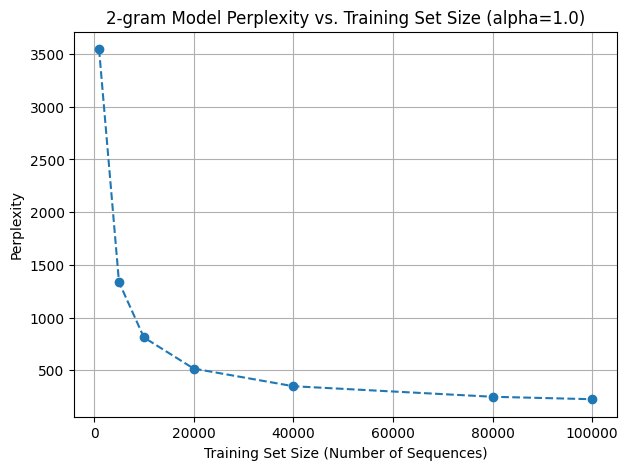

In [ ]:
def measure_ppl_vs_train_size(
    ngram_class,
    train_sizes,
    n,
    alpha,
    vocab,
    dataset_name="roneneldan/TinyStories"
):
    """
    Trains and evaluates perplexity for different training set sizes,
    then plots perplexity vs. training size.

    Args:
        ngram_class: Class implementing the n-gram LM (e.g., NgramLM).
        train_sizes: List of integers specifying maximum number of sequences to train on.
        n: Order of the n-gram (1=unigram, 2=bigram, etc.).
        alpha: Smoothing parameter (for alpha-smoothing in the n-gram model).
        vocab: Vocabulary object used for token indexing.
        dataset_name: Hugging Face dataset name (default: "roneneldan/TinyStories").
    """
    # We'll store (train_size, perplexity) for each experiment
    results = []

    for max_size in train_sizes:
        print(f"\n=== Training {n}-gram model with alpha={alpha}, "
              f"max train sequences={max_size} ===")

        # 1) Initialize model
        model = ngram_class(n=n, vocab_size=len(vocab), alpha=alpha)

        # 2) Train on train split (up to max_size sequences)
        model.train(train_data, vocab, max_train_sequences=max_size)

        # 3) Evaluate perplexity on dev
        ppl = evaluate_perplexity(model, dev_data, vocab)

        results.append((max_size, ppl))
        print(f"Training Size: {max_size}, Perplexity: {ppl:.4f}")

    # Plot the results
    train_sizes_list = [r[0] for r in results]
    perplexities = [r[1] for r in results]

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes_list, perplexities, marker='o', linestyle='--')
    plt.title(f"{n}-gram Model Perplexity vs. Training Set Size (alpha={alpha})")
    plt.xlabel("Training Set Size (Number of Sequences)")
    plt.ylabel("Perplexity")
    plt.grid(True)
    plt.show()


train_sizes_to_try = [1000, 5000, 10000, 20000, 40000, 80000, 100000]
measure_ppl_vs_train_size(NgramLM, train_sizes_to_try, n=2, alpha=1.0, vocab=vocab)


# Part III: Neural n-Gram Language Model

## 7. NeuralNgramLM Class with Training and Evaluation

In this section, we'll move beyond count-based n-gram models and implement a **feed-forward neural network** to predict the next token given an $(n-1)$-gram context. This model can share statistical strength across different contexts via **learned embeddings** and non-linear hidden layers.

We will:

- **Implement a `NeuralNgramLM` class** that parametrizes $p(w_k \mid w_{k-n+1}, \ldots, w_{k-1})$ using:
   - A word embedding layer.
   - Optionally, **pretrained** embeddings (e.g., from word2vec).
   - One or more hidden layers for non-linear transformations.
   - A softmax output layer over the vocabulary.

- **Load or initialize embeddings**:
   - We'll illustrate how to **download a pre-trained word2vec** embedding file (e.g., GloVe or another word2vec format) and incorporate those vectors into our model.
   - If a token isn't found in the pretrained embedding, we can initialize its vector randomly.

- **Training loop**:
   - We'll write a PyTorch-based training loop that tracks:
     - **Training loss** (negative log-likelihood).
     - **Perplexity on the dev set** after each epoch or mini-batch subset.
   - We'll **record the training time** for each epoch and visualize the learning curve (loss vs. steps or epochs).

- **Experiments**:
   - We'll run experiments varying **hyperparameters** such as:
     - Embedding dimension
     - Hidden layer size
     - Learning rate
     - Batch size
   - We'll track how **devset perplexity** changes across these configurations to find a good trade-off.


In [ ]:
import time
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class NeuralNgramLM(nn.Module):
    def __init__(
        self,
        n,
        vocab_size,
        embedding_dim=100,
        hidden_dim=200,
        pretrained_embeddings=None,
        freeze_embeddings=False
    ):
        """
        n: order of n-gram
        vocab_size: size of vocabulary
        embedding_dim: dimensionality of embeddings
        hidden_dim: size of the feed-forward hidden layer
        pretrained_embeddings: optional numpy array of shape [vocab_size, embedding_dim]
                               containing pre-trained word vectors
        freeze_embeddings: if True, the embedding layer will not be updated (frozen)
        """
        super().__init__()
        self.n = n
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # TODO: Initialize the embedding layer (nn.Embedding) with vocab_size and embedding_dim
        # [Inser your code here]

        if pretrained_embeddings is not None:
            # TODO: Load pretrained embeddings into the embedding layer
            # [Inser your code here]
            print("Loaded pretrained embeddings!")

            if freeze_embeddings:
                # TODO: Freeze the embedding layer weights if specified
                # [Inser your code here]
                pass

        # Next, we have a feed-forward that takes
        # (n-1) * embedding_dim as input
        self.ff_in_dim = (self.n - 1) * self.embedding_dim

        # TODO: Initialize the hidden layer (nn.Linear) with ff_in_dim and hidden_dim
        # [Inser your code here]

        # TODO: Initialize the output layer (nn.Linear) with hidden_dim and vocab_size
        # [Inser your code here]

        # Initialize activation functions
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, context):
        """
        context: tensor of shape (batch_size, n-1) with token IDs
                 (each row is the n-1 tokens in the context)

        returns: log probabilities of shape (batch_size, vocab_size)
        """
        # TODO: Embed each token in the context
        # [Inser your code here]

        # TODO: Flatten the embeddings to shape (batch_size, (n-1)*embedding_dim)
        # [Inser your code here]

        # TODO: Pass the flattened embeddings through the hidden layer and apply ReLU activation
        # [Inser your code here]

        # TODO: Pass the hidden activations through the output layer to get logits
        # [Inser your code here]

        # TODO: Apply log softmax to obtain log probabilities
        # [Inser your code here]

        pass

def load_pretrained_word2vec(vocab, file_path, embedding_dim):
    """
    file_path: path to the pretrained embeddings file
    embedding_dim: dimension of embeddings
    returns a numpy array of shape [vocab_size, embedding_dim]
    that we can feed into NeuralNgramLM
    """
    # Initialize random embeddings by default
    pretrained_matrix = np.random.uniform(
        low=-0.01, high=0.01, size=(len(vocab), embedding_dim)
    )

    # Load word2vec text file (example format: "word val1 val2 ... valD")
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != embedding_dim + 1:
                continue  # skip lines that don't match dimension

            w = parts[0]
            vec = parts[1:]
            # if w is in vocab, assign
            if vocab.token_exists(w):
                idx = vocab.token_to_idx[w]
                pretrained_matrix[idx] = np.array(vec, dtype=np.float32)

    return pretrained_matrix


def compute_perplexity(model, dev_loader, device):
    """
    Compute perplexity of the neural n-gram LM on dev set using dev_loader.
    dev_loader: yields (context_batch, next_token_batch) pairs.
    We'll compute loss in mini-batches.
    """
    model.eval()
    total_log_prob = 0.0
    total_count = 0

    with torch.no_grad():
        for context_batch, next_tok_batch in dev_loader:
            context_batch = context_batch.to(device)
            next_tok_batch = next_tok_batch.to(device)

            # TODO: Get log probabilities from the model
            # [Insert your code here]

            # TODO: Gather log probabilities for the correct next tokens
            # [Insert your code here]

            # TODO: Accumulate the total log probability and count
            # [Insert your code here]

    # TODO: Compute average log probability and perplexity
    return ppl

def train_neural_ngram(
    model,
    train_loader,
    dev_loader,
    device,
    lr=1e-3,
    gamma=0.95,
    num_epochs=5,
    print_every=100
):
    """
    Trains the model and logs more detailed information:
      - the batch size each iteration
      - total examples processed so far
    """
    model.to(device)

    # TODO: Create the optimizer
    # [Insert your code here]

    # TODO: Initialize the learning rate scheduler
    # [Insert your code here]

    # TODO: Define the loss criterion
    # [Insert your code here]

    train_losses = []
    dev_perplexities = []

    t0 = time.time()
    step = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_examples_epoch = 0  # how many instances processed this epoch

        # i is the mini-batch index, (context_batch, next_tok_batch) is the data
        for i, (context_batch, next_tok_batch) in enumerate(train_loader):
            context_batch = context_batch.to(device)
            next_tok_batch = next_tok_batch.to(device)

            batch_size = context_batch.size(0)
            total_examples_epoch += batch_size

            # TODO: Zero the gradients
            # [Insert your code here]

            # TODO: Perform a forward pass to get log probabilities
            # [Insert your code here]

            # TODO: Compute the loss
            # [Insert your code here]

            # TODO: Perform backpropagation
            # [Insert your code here]

            # TODO: Update the model parameters
            # [Insert your code here]

            # TODO: Accumulate the running loss
            # [Insert your code here]
            step += 1

            # TODO: Print training details
            # [Insert your code here]

        # TODO: Step the learning rate scheduler
        # [Insert your code here]

        # Compute and log dev perplexity
        ppl = compute_perplexity(model, dev_loader, device)
        dev_perplexities.append((step, ppl))
        print(f"End of Epoch {epoch+1}: Dev Perplexity = {ppl:.4f}")

    # TODO: Print total training time
    t1 = time.time()
    print(f"Training completed in {t1 - t0:.2f} seconds")
    return train_losses, dev_perplexities


def plot_training_curves(train_losses, dev_perplexities):
    """
    train_losses: list of (step, avg_loss)
    dev_perplexities: list of (step, ppl)
    """
    import matplotlib.pyplot as plt

    # Separate steps and values
    steps_loss = [x[0] for x in train_losses]
    loss_vals = [x[1] for x in train_losses]
    steps_ppl = [x[0] for x in dev_perplexities]
    ppl_vals = [x[1] for x in dev_perplexities]

    fig, ax1 = plt.subplots(figsize=(8,5))

    # Plot loss
    color1 = 'tab:blue'
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Training Loss', color=color1)
    ax1.plot(steps_loss, loss_vals, color=color1, label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color1)

    # Plot perplexity on second axis
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel('Dev Perplexity', color=color2)
    ax2.plot(steps_ppl, ppl_vals, color=color2, label='Dev PPL')
    ax2.tick_params(axis='y', labelcolor=color2)

    fig.tight_layout()
    plt.title("Training Loss and Dev Perplexity vs Steps")
    plt.show()

## 8. Preparing Data for the Neural $n$-Gram Model

To train the neural model, we need **(context, next token)** pairs in mini-batches. For an $n$-gram:
- We'll parse each sentence, prepend $(n-1)$ `<s>` tokens, and collect pairs:
  $$
    (\text{context} = w_{t-n+1 : t-1}, \text{next_tok} = w_t).
  $$
- We'll batch these examples for efficient GPU training.

The code below shows a small `collate_fn` or data-preparation logic:
1. Converts raw text to token IDs.
2. Splits into $n-1$-context + next token examples.
3. Yields mini-batches.


In [ ]:
import random
from torch.utils.data import IterableDataset, DataLoader

class NgramDataset(IterableDataset):
    def __init__(self, dataset_iter, vocab, n=3, max_sequences=None):
        """
        dataset_iter: dataset
        vocab: vocabulary object
        n: n-gram order
        max_sequences: optional limit of sequences to read
        """
        super().__init__()
        self.dataset_iter = dataset_iter
        self.vocab = vocab
        self.n = n
        self.max_sequences = max_sequences

    def __iter__(self):
        count_seq = 0
        for ex in self.dataset_iter:
            text = ex["text"]
            tokens = text.strip().split()
            token_ids = [self.vocab.to_index(t) for t in tokens]

            # Prepend (n-1) <s>
            context_pad = [self.vocab.token_to_idx["<s>"]] * (self.n - 1)
            token_ids = context_pad + token_ids

            for i in range(self.n - 1, len(token_ids)):
                context = token_ids[i - (self.n - 1): i]  # length n-1
                next_tok = token_ids[i]
                yield (context, next_tok)

            count_seq += 1
            if self.max_sequences is not None and count_seq >= self.max_sequences:
                break

def collate_ngram_fn(batch):
    # batch is a list of (context, next_tok) pairs
    contexts = []
    next_toks = []
    for ctx, nxt in batch:
        contexts.append(ctx)
        next_toks.append(nxt)

    # Convert to tensors
    context_tensor = torch.tensor(contexts, dtype=torch.long)
    next_tok_tensor = torch.tensor(next_toks, dtype=torch.long)
    return context_tensor, next_tok_tensor


def prepare_dataloaders_for_neural_ngram(
    dataset_name,
    vocab,
    n=3,
    batch_size=32,
    max_train_sequences=10000,
    max_dev_sequences=2000
):
    """
    Create train and dev DataLoaders for the neural n-gram model.
    We'll limit sequences if desired, then yield mini-batches.
    """
    train_dataset = NgramDataset(train_data, vocab, n=n, max_sequences=max_train_sequences)
    dev_dataset   = NgramDataset(dev_data, vocab, n=n, max_sequences=max_dev_sequences)

    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              collate_fn=collate_ngram_fn)
    dev_loader   = DataLoader(dev_dataset,
                              batch_size=batch_size,
                              collate_fn=collate_ngram_fn)
    return train_loader, dev_loader


## 9. Training a 3-gram Neural Model with Pretrained GloVe Embeddings

Below is a concise workflow for building and training a 3-gram neural language model using **pretrained embeddings** from GloVe (though you can skip loading if you prefer random initialization):

1. **Load** pretrained embeddings (e.g., GloVe) or skip if you want random initialization.
2. **Initialize** a `NeuralNgramLM(n=3, ...)` model, specifying embedding/hyperparameters.
3. **Prepare** your train/dev data using `prepare_dataloaders_for_neural_ngram`.
4. **Train** the model by calling `train_neural_ngram` to optimize embeddings and hidden layers.
5. **Plot** training curves with `plot_training_curves` to visualize loss and perplexity evolution.

**Word2Vec vs. GloVe**:  
- **Word2Vec** is a predictive method, learning embeddings by maximizing the probability of a context word given a target (or vice versa).  
- **GloVe** is a count-based approach, deriving embeddings by leveraging global co-occurrence statistics.  
Both yield meaningful word vectors that capture semantic relationships and can be plugged into our model for improved performance.


GloVe file already present.
Loaded pretrained embeddings!
Epoch [1/6], Step [500], Batch size: 512, Total examples this epoch: 256000, Avg Loss: 6.1315
Epoch [1/6], Step [1000], Batch size: 512, Total examples this epoch: 512000, Avg Loss: 5.1351
Epoch [1/6], Step [1500], Batch size: 512, Total examples this epoch: 768000, Avg Loss: 4.7924
Epoch [1/6], Step [2000], Batch size: 512, Total examples this epoch: 1024000, Avg Loss: 4.6000
Epoch [1/6], Step [2500], Batch size: 512, Total examples this epoch: 1280000, Avg Loss: 4.4247
Epoch [1/6], Step [3000], Batch size: 512, Total examples this epoch: 1536000, Avg Loss: 4.4570
End of Epoch 1: Dev Perplexity = 75.2276
Epoch [2/6], Step [500], Batch size: 512, Total examples this epoch: 256000, Avg Loss: 4.1837
Epoch [2/6], Step [1000], Batch size: 512, Total examples this epoch: 512000, Avg Loss: 4.1599
Epoch [2/6], Step [1500], Batch size: 512, Total examples this epoch: 768000, Avg Loss: 4.1326
Epoch [2/6], Step [2000], Batch size: 512, To

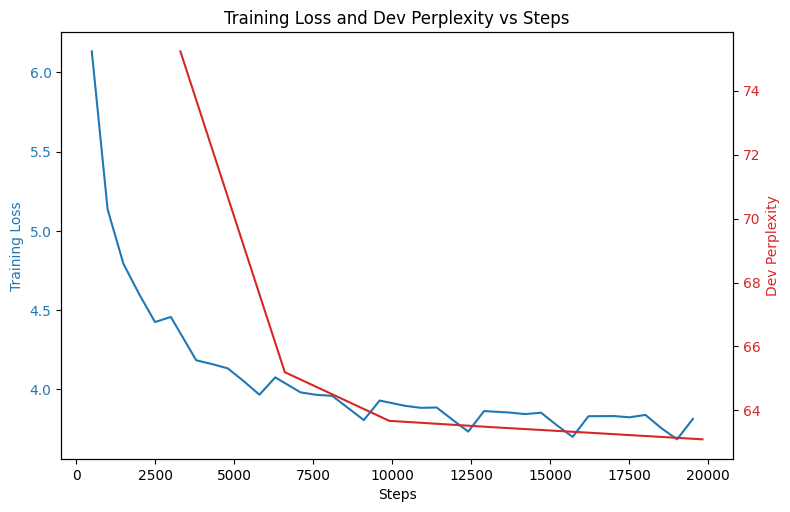

In [ ]:
# Example usage with GloVe 50-dimensional embeddings

import os
import requests
import gzip
import shutil

# 1) Download the GloVe file (compressed)
glove_url = "https://raw.githubusercontent.com/uclnlp/inferbeddings/master/data/glove/glove.6B.50d.txt.gz"
glove_gz = "glove.6B.50d.txt.gz"
glove_txt = "glove.6B.50d.txt"

if not os.path.exists(glove_txt):
    print("Downloading GloVe 50d embeddings...")
    r = requests.get(glove_url, stream=True)
    with open(glove_gz, "wb") as f:
        shutil.copyfileobj(r.raw, f)

    print("Decompressing the file...")
    with gzip.open(glove_gz, "rb") as f_in:
        with open(glove_txt, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)
    os.remove(glove_gz)
    print("Download and extraction complete!")
else:
    print("GloVe file already present.")


# 2) Load the pre-trained embeddings
embedding_dim = 50
pretrained_embs = load_pretrained_word2vec(
    vocab,
    file_path=glove_txt,
    embedding_dim=embedding_dim
)


# 3) Initialize the neural n-gram model
bigram_ffn = NeuralNgramLM(
    n=3,
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=200,
    pretrained_embeddings=pretrained_embs,
    freeze_embeddings=False
)


# 4) Prepare data loaders
#    (Adjust max_train_sequences / max_dev_sequences as desired)
train_loader, dev_loader = prepare_dataloaders_for_neural_ngram(
    dataset_name="roneneldan/TinyStories",
    vocab=vocab,
    n=3,
    batch_size=512,
    max_train_sequences=10000,  # train on 5k sequences for demonstration
    max_dev_sequences=3000     # dev on 1k sequences
)


# 5) Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_losses, dev_ppls = train_neural_ngram(
    model=bigram_ffn,
    train_loader=train_loader,
    dev_loader=dev_loader,
    device=device,
    lr=1e-3,
    gamma=0.5,
    num_epochs=6,
    print_every=500
)


# 6) Plot the training curves
plot_training_curves(train_losses, dev_ppls)


# Part IV: RNN-based Language Models

So far, we've explored count-based $n$-grams and feed-forward neural $n$-gram models.  
Now we'll build language models using **recurrent neural networks** (RNNs).
We'll implement two variants:

1. **Vanilla (Elman) RNN**: Uses the basic $\tanh$ recurrent cell.
2. **GRU**: Uses gated recurrent units to better handle long-range dependencies.

Both models will:
- Take a batch of sequences $[w_1, w_2, \ldots, w_T]$.
- Compute hidden states via RNN/GRU, then produce output logits and $\log$-probabilities for each position.
- Use a training loop that tracks **loss** on the training set and **perplexity** on the dev set, visualizing the curves.

We'll re-use some data-loading logic (batched sequences with `(input, target)` pairs) and the same approach for plotting results.


In [ ]:
#@title 10. Manual Vanilla RNN LM
import torch
import torch.nn as nn
import torch.optim as optim
import math
import time
from tqdm import tqdm

import torch
import torch.nn as nn

class ManualVanillaRNNLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=200):
        """
        Manually implemented Vanilla RNN language model (Elman RNN).
        This class does NOT use nn.RNN; instead, we implement the
        forward pass explicitly.

        Args:
          vocab_size (int): Size of the vocabulary.
          embedding_dim (int, optional): Dimension of word embeddings. Default is 100.
          hidden_dim (int, optional): Number of hidden units in the RNN. Default is 200.
        """
        super().__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # TODO: Initialize the embedding layer using nn.Embedding with vocab_size and embedding_dim
        # [Insert your code here]

        # TODO: Initialize the input-hidden linear layer (Wxh) with embedding_dim input and hidden_dim output
        # [Insert your code here]

        # TODO: Initialize the hidden-hidden linear layer (Whh) with hidden_dim input and hidden_dim output, without bias
        # [Insert your code here]

        # TODO: Initialize the output projection layer (Why) with hidden_dim input and vocab_size output
        # [Insert your code here]

        # Initialize activation functions
        self.tanh = nn.Tanh()
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_ids, h0=None):
        """
        Forward pass of the Vanilla RNN language model.

        Args:
          input_ids (torch.Tensor): Tensor of shape (batch_size, seq_len) containing token IDs.
          h0 (torch.Tensor, optional): Initial hidden state tensor of shape (batch_size, hidden_dim). If None, initializes to zeros.

        Returns:
          log_probs (torch.Tensor): Tensor of shape (batch_size, seq_len, vocab_size) containing log-probabilities for each token in the vocabulary at each time step.
          h_t (torch.Tensor): Final hidden state tensor of shape (batch_size, hidden_dim).
        """
        device = input_ids.device
        batch_size, seq_len = input_ids.size()

        # TODO: Initialize the hidden state h_t. If h0 is provided, use it; otherwise, initialize h_t to zeros.
        # [Insert your code here]

        # TODO: Embed the input_ids using the embedding layer to get embeddings of shape (batch_size, seq_len, embedding_dim)
        # [Insert your code here]

        # TODO: Initialize a list to store logits for each time step
        # [Insert your code here]

        # Iterate over each time step in the sequence
        for t in range(seq_len):
            # TODO: Extract embeddings for the current time step: x_t of shape (batch_size, embedding_dim)
            # [Insert your code here]

            # TODO: Compute the new hidden state h_t
            # [Insert your code here]

            # TODO: Compute logits for the next token using the output layer
            # [Insert your code here]

            # Unsqueeze logits_t to add a time dimension and append to logits_over_time
            logits_over_time.append(logits_t.unsqueeze(1))

        # TODO: Concatenate logits over the time dimension to form a tensor of shape (batch_size, seq_len, vocab_size)
        # [Insert your code here]

        # TODO: Apply log softmax to the logits to obtain log-probabilities
        # [Insert your code here]

        # Return the log probabilities and the final hidden state
        return log_probs, h_t


In [ ]:
#@title 11. Vanilla RNN Language Model Using ``nn.RNN``

class VanillaRNNLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=200, num_layers=1):
        """
        A simple RNN-based language model.

        Args:
            vocab_size (int): Size of the vocabulary.
            embedding_dim (int, optional): Dimension of embeddings. Default is 100.
            hidden_dim (int, optional): Number of hidden units in RNN. Default is 200.
            num_layers (int, optional): Number of stacked RNN layers. Default is 1.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # TODO: Initialize the embedding layer using nn.Embedding with vocab_size and embedding_dim
        # [Insert your code here]

        # TODO: Initialize the Elman RNN using nn.RNN with input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, and batch_first=True
        # [Insert your code here]

        # TODO: Initialize the output projection layer using nn.Linear with hidden_dim input and vocab_size output
        # [Insert your code here]

        # TODO: Initialize the log softmax layer using nn.LogSoftmax with dim=2
        # [Insert your code here]

    def forward(self, input_ids, hidden=None):
        """
        Forward pass of the Vanilla RNN language model.

        Args:
            input_ids (torch.Tensor): Tensor of shape (batch_size, seq_len) containing token indices.
            hidden (torch.Tensor, optional): Initial hidden state tensor of shape (num_layers, batch_size, hidden_dim). If None, initializes to zeros.

        Returns:
            log_probs (torch.Tensor): Tensor of shape (batch_size, seq_len, vocab_size) containing log-probabilities for each token in the vocabulary at each time step.
            hidden (torch.Tensor): Final hidden state tensor of shape (num_layers, batch_size, hidden_dim).
        """
        # TODO: Perform embedding lookup on input_ids
        # [Insert your code here]

        # TODO: Perform RNN forward pass with embeddings and hidden state
        # [Insert your code here]

        # TODO: Project RNN outputs to vocabulary size using the output projection layer
        # [Insert your code here]

        # TODO: Convert logits to log-probabilities using log softmax
        # [Insert your code here]

        # Return log_probs and the final hidden state
        return log_probs, hidden


In [ ]:
#@title 12. Vanilla RNN Language Model Using ``nn.GRU``

class GRULM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim=100,
        hidden_dim=200,
        num_layers=1,
        pretrained_embeddings=None,
        freeze_embeddings=False
    ):
        """
        A GRU-based language model that can optionally load pretrained embeddings.

        Args:
            vocab_size (int): Size of the vocabulary.
            embedding_dim (int, optional): Dimension of embeddings. Default is 100.
            hidden_dim (int, optional): Number of hidden units in GRU. Default is 200.
            num_layers (int, optional): Number of stacked GRU layers. Default is 1.
            pretrained_embeddings (numpy.ndarray, optional): Pretrained embeddings of shape [vocab_size, embedding_dim].
            freeze_embeddings (bool, optional): Whether to freeze the embedding layer. Default is False.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        if pretrained_embeddings is not None:
            # Copy pretrained numpy array into the embedding layer
            emb_tensor = torch.FloatTensor(pretrained_embeddings)
            self.embedding.weight.data.copy_(emb_tensor)
            print("Loaded pretrained embeddings into GRULM!")

            if freeze_embeddings:
                self.embedding.weight.requires_grad = False

        # TODO: Initialize the GRU layer using nn.GRU with input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True
        # [Insert your code here]

        # TODO: Initialize the output projection layer using nn.Linear with hidden_dim input and vocab_size output
        # [Insert your code here]

        # Initialize log softmax
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_ids, hidden=None):
        """
        Forward pass of the GRU-based language model.

        Args:
            input_ids (torch.Tensor): Tensor of shape (batch_size, seq_len) containing token indices.
            hidden (torch.Tensor, optional): Initial hidden state tensor of shape (num_layers, batch_size, hidden_dim). If None, initializes to zeros.

        Returns:
            log_probs (torch.Tensor): Tensor of shape (batch_size, seq_len, vocab_size) containing log-probabilities for each token in the vocabulary at each time step.
            hidden (torch.Tensor): Final hidden state tensor of shape (num_layers, batch_size, hidden_dim).
        """
        # TODO: Embed the input_ids using the embedding layer
        # [Insert your code here]

        # TODO: Pass the embeddings through the GRU layer to obtain outputs and the final hidden state
        # [Insert your code here]

        # TODO: Project the GRU outputs to the vocabulary size using the output projection layer
        # [Insert your code here]

        # TODO: Convert logits to log-probabilities using log softmax
        # [Insert your code here]

        # Return the log probabilities and the final hidden state
        return log_probs, hidden


In [ ]:
#@title 13. Training & Evaluation Routines

def train_rnn_lm(
    model,
    train_loader,
    dev_loader,
    device,
    lr=1e-3,
    num_epochs=5,
    print_every=100
):
    """
    Train an RNN-based LM (Vanilla or GRU).
    The data loader yields (input_seq, target_seq), both shape: (batch_size, seq_len)
    where target_seq[i] is the next token for input_seq[i].
    We'll compute cross-entropy at each position in the sequence.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss(ignore_index=0)

    train_losses = []
    dev_perplexities = []

    step = 0
    t0 = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (input_seq, target_seq) in enumerate(train_loader):
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)

            # forward
            optimizer.zero_grad()
            log_probs, _ = model(input_seq)  # shape: (batch_size, seq_len, vocab_size)

            # Reshape for NLLLoss => we want (batch_size*seq_len, vocab_size) vs. (batch_size*seq_len)
            batch_size, seq_len, vocab_sz = log_probs.shape
            log_probs_2d = log_probs.view(batch_size*seq_len, vocab_sz)
            targets_1d = target_seq.view(batch_size*seq_len)

            # compute cross-entropy
            loss = criterion(log_probs_2d, targets_1d)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            step += 1

            if (i+1) % print_every == 0:
                avg_loss = running_loss / print_every
                train_losses.append((step, avg_loss))
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {avg_loss:.4f}")
                running_loss = 0.0

        # end of epoch => measure dev perplexity
        ppl = evaluate_rnn_ppl(model, dev_loader, device)
        dev_perplexities.append((step, ppl))
        print(f"End of Epoch {epoch+1}: Dev Perplexity = {ppl:.4f}")

    t1 = time.time()
    print(f"Training finished in {t1 - t0:.2f} seconds.")
    return train_losses, dev_perplexities


def evaluate_rnn_ppl(model, dev_loader, device):
    """
    Compute perplexity on the dev set by summing log probabilities
    at each position in each sequence.
    """
    model.eval()
    total_log_prob = 0.0
    total_tokens = 0

    criterion = nn.NLLLoss(reduction='sum', ignore_index=0)

    with torch.no_grad():
        for (input_seq, target_seq) in dev_loader:
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)

            log_probs, _ = model(input_seq)

            batch_size, seq_len, vocab_sz = log_probs.shape
            log_probs_2d = log_probs.view(batch_size*seq_len, vocab_sz)
            targets_1d = target_seq.view(batch_size*seq_len)

            # sum of negative log-likelihood
            loss_sum = criterion(log_probs_2d, targets_1d)  # sum of -logP for valid tokens
            total_log_prob += -loss_sum.item()  # switch sign because it's negative log
            # we count how many tokens are valid
            total_tokens += (targets_1d != 0).long().sum().item()  # if we used 0 as ignore

    avg_log_prob = total_log_prob / (total_tokens + 1e-9)
    ppl = math.exp(-avg_log_prob)
    return ppl


In [ ]:
def plot_training_curves(train_losses, dev_perplexities, title="RNN LM Training"):
    steps_loss = [x[0] for x in train_losses]
    loss_vals  = [x[1] for x in train_losses]

    steps_ppl  = [x[0] for x in dev_perplexities]
    ppl_vals   = [x[1] for x in dev_perplexities]

    fig, ax1 = plt.subplots(figsize=(8, 5))

    color1 = "tab:blue"
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("Training Loss", color=color1)
    ax1.plot(steps_loss, loss_vals, color=color1, label="Train Loss")
    ax1.tick_params(axis="y", labelcolor=color1)

    ax2 = ax1.twinx()
    color2 = "tab:red"
    ax2.set_ylabel("Dev Perplexity", color=color2)
    ax2.plot(steps_ppl, ppl_vals, color=color2, label="Dev PPL")
    ax2.tick_params(axis="y", labelcolor=color2)

    fig.tight_layout()
    plt.title(title)
    plt.show()


## 14. Data Preparation for RNNs

For RNN-based LMs, we typically process sequences in mini-batches:
- The `(input_seq, target_seq)` approach: each token in `target_seq` is the "next token" for the corresponding position in `input_seq`.
- If using padding, we must choose an ignore index (e.g., -1 or 0) for computing the loss only on valid tokens.

We can use a similar approach to the feed-forward data loader, except now we treat entire sequences (or segments) rather than single $(n-1)$-grams. Below is an example of how to adapt the data loader for RNN usage. (You can re-use or adapt your existing dataset logic, ensuring that `(input_seq, target_seq)` align correctly with RNN training.)


In [ ]:
from torch.utils.data import IterableDataset, DataLoader

class RNNLanguageDataset(IterableDataset):
    def __init__(self, dataset_iter, vocab, max_seq_len=50, max_sequences=None):
        super().__init__()
        self.dataset_iter = dataset_iter
        self.vocab = vocab
        self.max_seq_len = max_seq_len
        self.max_sequences = max_sequences

    def __iter__(self):
        count_seq = 0
        for ex in self.dataset_iter:
            text = ex["text"]
            tokens = text.strip().split()
            token_ids = [self.vocab.to_index(t) for t in tokens]

            # Optionally break into chunks of length max_seq_len
            # For each chunk: input_seq is chunk[:-1], target_seq is chunk[1:]
            # Here we do a simple approach if len(chunk) > 1
            i = 0
            while i < len(token_ids) - 1:
                end_i = min(i + self.max_seq_len, len(token_ids))
                chunk = token_ids[i:end_i]

                # input_seq is chunk[:-1], target_seq is chunk[1:]
                input_seq = chunk[:-1]
                target_seq = chunk[1:]

                # If length < 2, skip
                if len(input_seq) < 1:
                    break

                yield (input_seq, target_seq)
                i += self.max_seq_len

            count_seq += 1
            if self.max_sequences is not None and count_seq >= self.max_sequences:
                break

def collate_rnn_fn(batch, pad_idx=0):
    """
    batch: list of (input_seq, target_seq) with variable lengths
    We'll pad them to the same length within the batch, set padded tokens to pad_idx.
    """
    lengths = [len(x[0]) for x in batch]
    max_len = max(lengths)

    # Prepare tensors
    # input_batch, target_batch => shape (batch_size, max_len)
    input_batch = []
    target_batch = []

    for (inp, tgt) in batch:
        # pad to max_len
        padded_inp = inp + [pad_idx]*(max_len - len(inp))
        padded_tgt = tgt + [pad_idx]*(max_len - len(tgt))
        input_batch.append(padded_inp)
        target_batch.append(padded_tgt)

    input_tensor = torch.tensor(input_batch, dtype=torch.long)
    target_tensor = torch.tensor(target_batch, dtype=torch.long)
    return input_tensor, target_tensor

def prepare_rnn_dataloaders(train_data, dev_data, vocab, batch_size=32, max_seq_len=50, max_train_sequences=2000, max_dev_sequences=500):
    train = RNNLanguageDataset(train_data, vocab, max_seq_len=max_seq_len, max_sequences=max_train_sequences)
    dev   = RNNLanguageDataset(dev_data, vocab, max_seq_len=max_seq_len, max_sequences=max_dev_sequences)

    train_loader = DataLoader(
        train,
        batch_size=batch_size,
        collate_fn=lambda b: collate_rnn_fn(b, pad_idx=0)
    )
    dev_loader   = DataLoader(
        dev,
        batch_size=batch_size,
        collate_fn=lambda b: collate_rnn_fn(b, pad_idx=0)
    )

    return train_loader, dev_loader


## 15. Train and Evaluate the Model

1. **Create** an RNN-based LM (either `ManualVanillaRNNLM`, `VanillaRNNLM` or `GRULM`).
2. **Prepare** a streaming dataset to produce `(input_seq, target_seq)` mini-batches for train & dev.
3. **Train** the model via `train_rnn_lm(...)`, collecting losses and dev perplexities.
4. **Plot** the training curves with `plot_training_curves(...)`.


In [ ]:
# Example usage:

# 1) device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) Prepare data
train_loader, dev_loader = prepare_rnn_dataloaders(
    train_data=train_data,
    dev_data=dev_data,
    vocab=vocab,
    batch_size=128,
    max_seq_len=50,
    max_train_sequences=10000,
    max_dev_sequences=3000
)

# 3) Load the pre-trained embeddings
glove_txt = "glove.6B.50d.txt"
embedding_dim = 50
pretrained_embs = load_pretrained_word2vec(
    vocab,
    file_path=glove_txt,
    embedding_dim=embedding_dim
)

# 4) Initialize a GRU language model
fullcontext_gru = GRULM(
    vocab_size=len(vocab),
    embedding_dim=50,
    hidden_dim=200,
    pretrained_embeddings=pretrained_embs,
    freeze_embeddings=False
)

# 5) Train
train_losses, dev_ppls = train_rnn_lm(
    model=fullcontext_gru,
    train_loader=train_loader,
    dev_loader=dev_loader,
    device=device,
    lr=1e-3,
    num_epochs=5,
    print_every=50
)


Loaded pretrained embeddings into GRULM!
Epoch [1/5], Step [50], Loss: 7.6961
Epoch [1/5], Step [100], Loss: 6.7909
Epoch [1/5], Step [150], Loss: 6.6421
Epoch [1/5], Step [200], Loss: 6.4404
Epoch [1/5], Step [250], Loss: 6.2579
Epoch [1/5], Step [300], Loss: 6.1286
End of Epoch 1: Dev Perplexity = 1581.9124
Epoch [2/5], Step [50], Loss: 5.8942
Epoch [2/5], Step [100], Loss: 5.7280
Epoch [2/5], Step [150], Loss: 5.5599
Epoch [2/5], Step [200], Loss: 5.3509
Epoch [2/5], Step [250], Loss: 5.2888
Epoch [2/5], Step [300], Loss: 5.2786
End of Epoch 2: Dev Perplexity = 927.1804
Epoch [3/5], Step [50], Loss: 5.1856
Epoch [3/5], Step [100], Loss: 5.1081
Epoch [3/5], Step [150], Loss: 5.0329
Epoch [3/5], Step [200], Loss: 4.8770
Epoch [3/5], Step [250], Loss: 4.8641
Epoch [3/5], Step [300], Loss: 4.9017
End of Epoch 3: Dev Perplexity = 695.7938
Epoch [4/5], Step [50], Loss: 4.8463
Epoch [4/5], Step [100], Loss: 4.7955
Epoch [4/5], Step [150], Loss: 4.7511
Epoch [4/5], Step [200], Loss: 4.5996


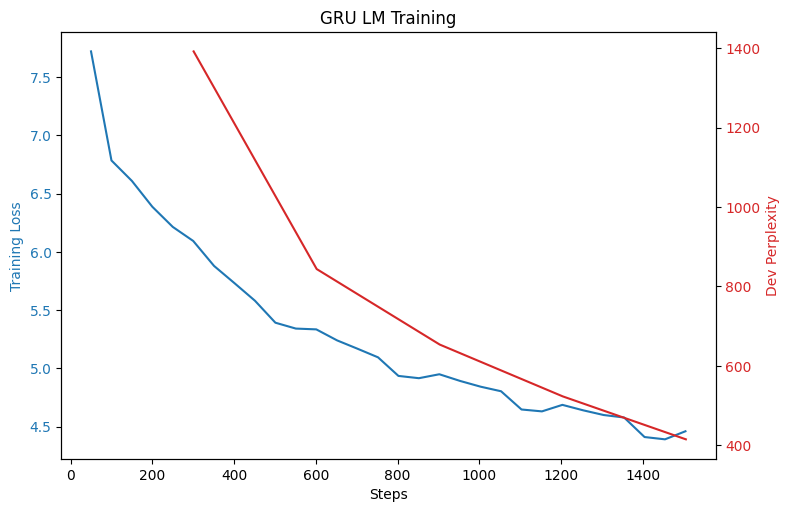

In [ ]:
# 6) Plot
plot_training_curves(train_losses, dev_ppls, title="GRU LM Training")

# Part V: Text Generation with Greedy Decoding and Temperature Sampling

So far, we've focused on **training** and **evaluating** language models via perplexity. Another important aspect is **text generation**: using our models to produce new sequences token-by-token.

We'll explore two popular decoding strategies:
1. **Greedy Decoding**: At each step, choose the most probable next token $\arg\max p_{\theta}(w)$.
2. **Sampling (with Temperature)**: Randomly draw the next token from the model's probability distribution, optionally adjusting **temperature** $T$ (where $T>1$ increases randomness, $T<1$ makes the distribution more peaked).

We'll demonstrate these strategies for:
- **Count-based n-gram LM**
- **Feed-forward n-gram LM**
- **RNN-based LM** (the same logic can be applied to GRU or manual RNN classes).

Finally, we'll compare the outputs qualitatively (e.g., how repetitive or diverse they are).


In [ ]:
#@title Generation for n-Gram Model

def generate_text_ngram(
    model,
    vocab,
    max_length=30,
    strategy="greedy",
    temperature=1.0
):
    """
    Generate text from an n-gram model, token-by-token.

    Args:
        model: an instance of NgramLM (count-based).
        vocab: the vocabulary object for mapping token IDs <-> strings.
        max_length: maximum number of tokens to generate.
        strategy: "greedy" or "sample"
        temperature: float > 0, used when strategy="sample".

    Returns:
        A list of generated tokens (strings).
    """
    if not model.is_trained:
        raise ValueError("N-gram model not trained yet.")

    # We keep the last n-1 tokens in a list; initially (n-1) <s>
    context = [vocab.token_to_idx["<s>"]] * (model.n - 1)
    generated_ids = []

    for _ in range(max_length):
        # We get probabilities of the next token
        context_tuple = tuple(context)

        # For each token in the vocab, compute p(next_token|context)
        # p = (count(context,next) + alpha) / (count(context) + alpha*vocab_size)
        # We can use a "softmax" if sampling, but for n-gram we can just
        # compute each candidate probability directly from model.conditional_counts.

        cxt_count = model.context_counts.get(context_tuple, 0)
        next_token_probs = []
        for token_id in range(model.vocab_size):
            # [Insert your code here]
            next_token_probs.append(prob)

        next_token_probs = np.array(next_token_probs)

        if strategy == "greedy":
            # pick argmax
            next_id = int(next_token_probs.argmax())
        elif strategy == "sample":
            # apply temperature
            if temperature <= 0:
                raise ValueError("Temperature must be > 0")
            # we do p_i^(1/T) / sum_j p_j^(1/T)
            # [Insert your code here]
        else:
            raise ValueError("strategy must be 'greedy' or 'sample'")

        # If next_id is </s>, we stop
        if next_id == vocab.token_to_idx["</s>"]:
            break

        # append to generation
        generated_ids.append(next_id)

        # update context
        if model.n > 1:
            context = context[1:] + [next_id]

    # convert IDs back to tokens
    generated_tokens = [vocab.to_token(i) for i in generated_ids]
    return generated_tokens



In [ ]:
#@title Generation for n-Gram FF Model

def generate_text_neural_ngram(
    model,
    vocab,
    device,
    max_length=30,
    strategy="greedy",
    temperature=1.0
):
    """
    Generate text from a feed-forward neural n-gram model.

    Similar approach, but we use the model.forward(context) => log_probs
    and pick next token by either greedy or sampling.
    """
    model.eval()

    # Start with (n-1) <s>
    context = [vocab.token_to_idx["<s>"]] * (model.n - 1)
    generated_ids = []

    for _ in range(max_length):
        # Make context a batch of size 1: shape (1, n-1)
        context_tensor = torch.tensor([context], dtype=torch.long, device=device)

        with torch.no_grad():
            log_probs = model(context_tensor)  # shape: (1, vocab_size)
            probs = torch.exp(log_probs).squeeze(0)  # shape: (vocab_size,)

        # Convert to CPU numpy for sampling, or handle in PyTorch
        probs_np = probs.cpu().numpy()

        if strategy == "greedy":
            next_id = int(np.argmax(probs_np))
        elif strategy == "sample":
            if temperature <= 0:
                raise ValueError("Temperature must be > 0")
            scaled = np.power(probs_np, 1.0/temperature)
            scaled /= scaled.sum()
            next_id = np.random.choice(len(scaled), p=scaled)
        else:
            raise ValueError("strategy must be 'greedy' or 'sample'")

        if next_id == vocab.token_to_idx["</s>"]:
            break

        generated_ids.append(next_id)

        # Slide context
        if model.n > 1:
            context = context[1:] + [next_id]

    tokens = [vocab.to_token(i) for i in generated_ids]
    return tokens


In [ ]:
#@title Generation for RNN Models

def generate_text_rnn(
    model,
    vocab,
    device,
    max_length=50,
    strategy="greedy",
    temperature=1.0
):
    """
    Auto-regressive generation from an RNN-based LM (Vanilla or GRU),
    using the previous hidden state at each step.

    We'll start with a single token <s>. On each step:
      1) Feed the last chosen token (shape: (1,1)) to the model, along with the
         previous hidden state.
      2) The model returns log_probs for that step plus the updated hidden state.
      3) We pick the next token via greedy or sampling.
      4) Continue until </s> or max_length is reached.
    """
    model.eval()

    # Start with <s>
    current_id = vocab.token_to_idx["<s>"]
    generated_ids = []

    # We'll keep track of the hidden state across steps
    hidden = None

    for _ in range(max_length):
        # TODO: Create a single-token batch: shape (1,1)
        # [Insert your code here]

        with torch.no_grad():
            # TODO: Perform a forward pass to get log_probs and updated hidden state
            # [Insert your code here]

        # TODO: Extract the distribution for the current time step
        # [Insert your code here]

        # TODO: Pick the next token based on the chosen strategy (greedy or sample)
        if strategy == "greedy":
            next_id = # [Insert your code here]
        elif strategy == "sample":
            if temperature <= 0:
                raise ValueError("Temperature must be > 0")
            scaled = np.power(probs, 1.0 / temperature)
            scaled /= scaled.sum()
            next_id = # [Insert your code here]
        else:
            raise ValueError("strategy must be 'greedy' or 'sample'")

        # TODO: Check if the next token is the end token </s>
        if next_id == vocab.token_to_idx["</s>"]:
            break

        # TODO: Append the next token to the generated sequence and update current_id
        # [Insert your code here]

    # Convert generated token IDs back to tokens
    tokens = [vocab.to_token(idx) for idx in generated_ids]
    return tokens


In [ ]:
#@title Comparison Routine

def compare_generation_strategies(
    model_list,
    model_names,
    vocab,
    device,
    max_length=20,
    temps=(0.7, 1.0, 1.5)
):
    """
    For each model in model_list, we generate text using:
      - Greedy decoding
      - Sampling with different temperatures (in temps)
    Print or return the results for quick comparison.
    """
    for mdl, name in zip(model_list, model_names):
        print(f"\n=== Model: {name} ===")

        # Distinguish if it's an n-gram model or a neural model by checking type
        if hasattr(mdl, 'conditional_counts'):  # Likely an NgramLM
            # For n-gram
            print("  [Greedy]")
            greedy_text = generate_text_ngram(mdl, vocab, max_length, "greedy")
            print("   ", " ".join(greedy_text))

            for t in temps:
                print(f"  [Sample, T={t}]")
                sample_text = generate_text_ngram(mdl, vocab, max_length, "sample", temperature=t)
                print("   ", " ".join(sample_text))

        elif isinstance(mdl, torch.nn.Module):
            # We check if it's feed-forward or RNN by seeing if 'forward' takes context or sequences
            # Let's do a small check if it has an attribute 'n' => neural n-gram
            if hasattr(mdl, 'n'):
                # It's a feed-forward n-gram
                print("  [Greedy]")
                greedy_text = generate_text_neural_ngram(mdl, vocab, device, max_length, "greedy")
                print("   ", " ".join(greedy_text))

                for t in temps:
                    print(f"  [Sample, T={t}]")
                    sample_text = generate_text_neural_ngram(mdl, vocab, device, max_length, "sample", t)
                    print("   ", " ".join(sample_text))
            else:
                # It's an RNN-based LM
                print("  [Greedy]")
                greedy_text = generate_text_rnn(mdl, vocab, device, max_length, "greedy")
                print("   ", " ".join(greedy_text))

                for t in temps:
                    print(f"  [Sample, T={t}]")
                    sample_text = generate_text_rnn(mdl, vocab, device, max_length, "sample", t)
                    print("   ", " ".join(sample_text))

        else:
            print("Unrecognized model type, skipping.")


In [ ]:
#@title Run Comparison
all_models = [bigram_model_a01, bigram_ffn, fullcontext_gru]
all_names = ["Count-based N-gram", "Neural N-gram", "RNN LM"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

compare_generation_strategies(
    model_list=all_models,
    model_names=all_names,
    vocab=vocab,
    device=device,
    max_length=50,
    temps=(0.5, 0.7, 1.0, 1.2, 1.5)
)


=== Model: Count-based N-gram ===
  [Greedy]
    Once upon a time, there was a time, there was a time, there was a time, there was a time, there was a time, there was a time, there was a time, there was a time, there was a time, there was a time, there was a time, there was
  [Sample, T=0.5]
    Once upon a time, there was a little girl named Lily. She was very proud of the boy named Lily. She ran to the park. They go to put them and bought a big and said, "That's a time, there was a little girl named Lily. She felt sad and
  [Sample, T=0.7]
    One day, a big dog. volcano, 'Wow!' cat's Bud musicians understand," Mum?" item isn't nightstand. written. Moral: will!" milk!" these," the puppy prayed medal maze?" efforts. us!" him," sorted fruits. symbols. Are nice, minerals. Elsa. Suzie king!" "Spray rushes spilling. atmosphere weeping?" watching." existed. silly and said, "I scary." Suzie
  [Sample, T=1.0]
    happy.â€ Katy's cup cartoon. â€œ hours! Nappy After is,â€ too". laughs kind-he